In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/7th Sem/archive (1)'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
df = pd.read_csv("/content/drive/MyDrive/7th Sem/archive (1)/full_df.csv")
df.head()

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/7th Sem/archive (1)/ODIR-5K/ODIR-5K/Training Images/2910_left.jpg
/content/drive/MyDrive/7th Sem/archive (1)/ODIR-5K/ODIR-5K/Training Images/2870_right.jpg
/content/drive/MyDrive/7th Sem/archive (1)/ODIR-5K/ODIR-5K/Training Images/2883_left.jpg
/content/drive/MyDrive/7th Sem/archive (1)/ODIR-5K/ODIR-5K/Training Images/2884_left.jpg
/content/drive/MyDrive/7th Sem/archive (1)/ODIR-5K/ODIR-5K/Training Images/2908_left.jpg
/content/drive/MyDrive/7th Sem/archive (1)/ODIR-5K/ODIR-5K/Training Images/2869_left.jpg
/content/drive/MyDrive/7th Sem/archive (1)/ODIR-5K/ODIR-5K/Training Images/2878_right.jpg
/content/drive/MyDrive/7th Sem/archive (1)/ODIR-5K/ODIR-5K/Training Images/2882_right.jpg
/content/drive/MyDrive/7th Sem/archive (1)/ODIR-5K/ODIR-5K/Training Images/2897_left.jpg
/content/drive/MyDrive/7th Sem/archive (1)/ODIR-5K/ODIR-5K/Training Images/2895_left.jpg
/content/drive/MyDrive/7th Sem/archive (1)/ODIR-5K/ODIR-

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
#Extracting Cataract & Normal information from the Dataset
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
print(left_cataract[:10])
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
print(right_cataract[:15])

['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg']
['24_right.jpg' '81_right.jpg' '112_right.jpg' '188_right.jpg'
 '218_right.jpg' '345_right.jpg' '354_right.jpg' '477_right.jpg'
 '553_right.jpg' '560_right.jpg' '625_right.jpg' '726_right.jpg'
 '769_right.jpg' '949_right.jpg' '955_right.jpg']


In [ ]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [ ]:
#Normal Images
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [ ]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [ ]:
print(len(cataract),len(normal))

594 600


In [ ]:
#Creating Dataset from images
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/drive/MyDrive/7th Sem/archive (1)/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset


In [ ]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [02:43<00:00,  3.62it/s] 


In [ ]:
len(dataset)

588

In [ ]:
dataset = create_dataset(normal,0)

100%|██████████| 600/600 [05:00<00:00,  2.00it/s]


In [ ]:
len(dataset)

1188

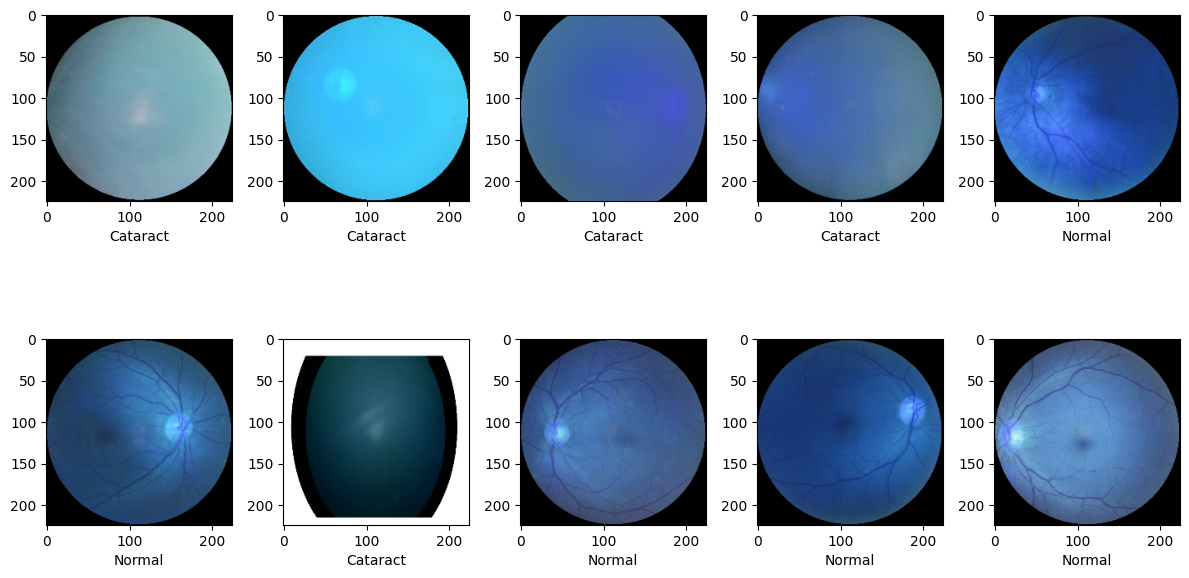

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
#Dividing dataset into x(features) & y(target)
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
#Creating Model
from keras.applications.vgg19 import VGG19, preprocess_input
vgg19_weight_path = '/content/drive/MyDrive/7th Sem/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg = VGG19(
    weights=vgg19_weight_path,
    include_top=False,
    input_shape=(224,224,3)
)

In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(Dense(128, activation='sigmoid'))
model.add(layers.Dropout(rate=0.2))
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dense (Dense)               (None, 7, 7, 256)         131328    
                                                                 
 dropout (Dropout)           (None, 7, 7, 256)         0         
                                                                 
 dense_1 (Dense)             (None, 7, 7, 128)         32896     
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 dense_2 (Dense)             (None, 7, 7, 128)         16512     
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 128)         0

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
history = model.fit(x_train,y_train,batch_size=32,epochs=5,validation_data=(x_test,y_test))

Epoch 1/5
30/30 [==============================] - 950s 31s/step - loss: 0.1039 - accuracy: 0.9611 - val_loss: 0.1954 - val_accuracy: 0.9412
Epoch 2/5
30/30 [==============================] - 863s 29s/step - loss: 0.0877 - accuracy: 0.9705 - val_loss: 0.1702 - val_accuracy: 0.9496
Epoch 3/5
30/30 [==============================] - 857s 29s/step - loss: 0.0774 - accuracy: 0.9716 - val_loss: 0.1877 - val_accuracy: 0.9538
Epoch 4/5
30/30 [==============================] - 892s 30s/step - loss: 0.0574 - accuracy: 0.9832 - val_loss: 0.1515 - val_accuracy: 0.9580
Epoch 5/5
30/30 [==============================] - 872s 29s/step - loss: 0.0470 - accuracy: 0.9821 - val_loss: 0.1675 - val_accuracy: 0.9496


In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

8/8 [==============================] - 182s 21s/step - loss: 0.1675 - accuracy: 0.9496
loss: 0.16752342879772186
Accuracy: 0.9495798349380493


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict(x_test)
threshold = 0.5  # Adjust the threshold as needed
y_pred_binary = np.where(y_pred >= threshold, 1, 0)

8/8 [==============================] - 170s 20s/step


In [ ]:
print(accuracy_score(y_test,y_pred_binary))

0.9495798319327731


In [ ]:
print(classification_report(y_test,y_pred_binary))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       126
           1       0.92      0.97      0.95       112

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238



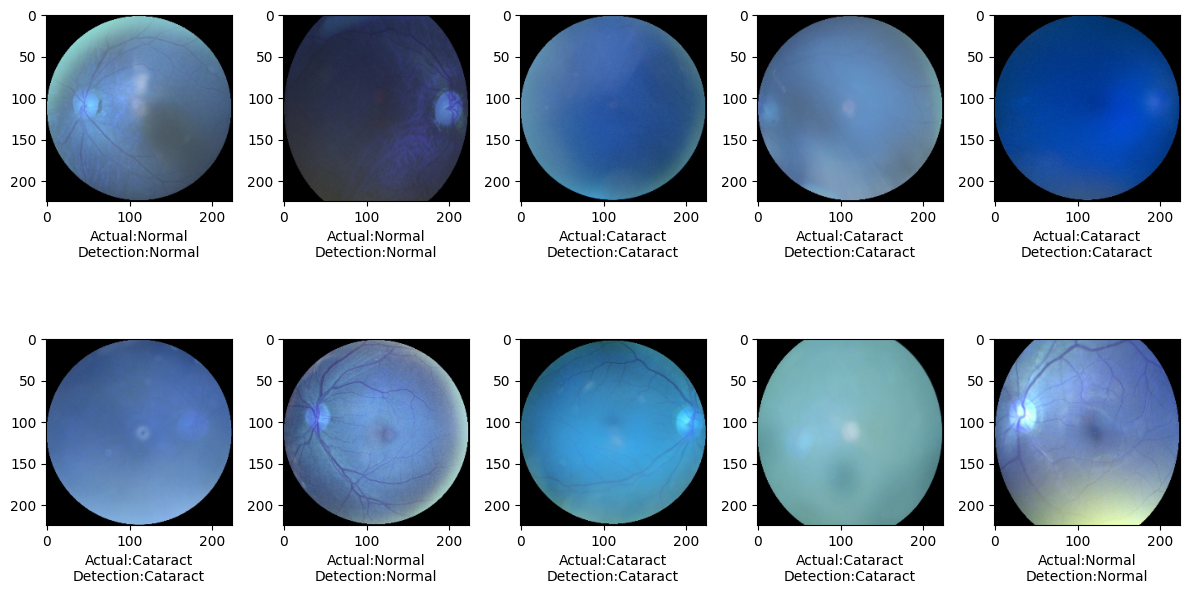

In [ ]:
#Detection:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred_binary[sample]

    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nDetection:{}".format(label,pred_label))
plt.tight_layout()